In [ ]:
%load_ext tensorboard
%tensorflow_version 2.x
!rm -rf ./logs/ 

TensorFlow 2.x selected.


In [ ]:
from __future__ import print_function

import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras import backend as K
from scipy import ndimage
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

batch_size = 50
num_classes = 10
epochs = 30
num_train_samples = 1000
val_sample_size = 5000

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step


60000 train samples


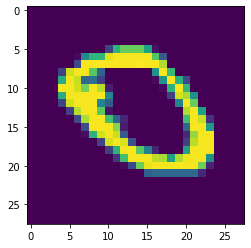

In [ ]:
def rotate_image(images, degrees):
    rot_images = []
    for image in images:
        img_rot = ndimage.rotate(image, degrees, reshape=False)
        rot_images.append(img_rot.reshape(28, 28))
    return np.array(rot_images)

# applying transformation to image
plt.imshow(x_train[1].reshape(28, 28))
img_rot = ndimage.rotate(x_train[1], 90, reshape=False)
plt.imshow(img_rot.reshape(28, 28))

x_train_rot = rotate_image(x_train, 30)
x_test_rot = rotate_image(x_test, 30)
    
print(x_train_rot.shape[0], 'train samples')

def reshapeImages(images):
    images = images.reshape(images.shape[0], images.shape[1]*images.shape[2])
    images = images.astype('float32')
    images /= 255
    print(images.shape[0], 'samples')
    return (images)

def show_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'test_accuracy'], loc='best')
    plt.show()
    
def show_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('#f Iterations')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [ ]:
x_val = reshapeImages(x_train)[-val_sample_size:]
x_train = reshapeImages(x_train)[:num_train_samples]
x_test = reshapeImages(x_test)
x_val_rot = reshapeImages(x_train_rot)[-val_sample_size:]
x_train_rot = reshapeImages(x_train_rot)[:num_train_samples]
x_test_rot = reshapeImages(x_test_rot)

# convert class vectors to binary class matrices
y_val = keras.utils.to_categorical(y_train, num_classes)[-val_sample_size:]
y_train = keras.utils.to_categorical(y_train, num_classes)[:num_train_samples]
y_test = keras.utils.to_categorical(y_test, num_classes)

60000 samples
60000 samples
10000 samples
60000 samples
60000 samples
10000 samples


In [ ]:
# first model (training of whole model)
input1 = keras.layers.Input(shape=(784, ))
dense1 = keras.layers.Dense(128, activation='relu')(input1)
dense2 = keras.layers.Dense(128, activation='relu')(dense1)
dense3 = keras.layers.Dense(20, activation='relu')(dense2)
output = keras.layers.Dense(num_classes, activation='softmax')(dense3)

model = keras.Model(inputs=input1, outputs=[dense3,output])

model.compile(loss='categorical_crossentropy',
              optimizer='Adadelta',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2580      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
Total params: 119,782
Trainable params: 119,782
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Instantiate an optimizer to train the model.
optimizer = tf.compat.v1.train.AdamOptimizer()
# Instantiate a loss function.
loss_cc = keras.losses.CategoricalCrossentropy(from_logits=True)

# Prepare the metrics.
train_acc_metric = keras.metrics.CategoricalAccuracy()
val_acc_metric = keras.metrics.CategoricalAccuracy()

# Prepare the training datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

train_dataset_rot = tf.data.Dataset.from_tensor_slices((x_train_rot, y_train))
train_dataset_rot = train_dataset_rot.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((np.concatenate((x_val,x_val_rot)), np.concatenate((y_val,y_val))))
val_dataset = val_dataset.batch(batch_size)

In [ ]:
def distance_loss(predictions, predictions_rot, ys, ys_rot):
    def calculate_distance(tensor):
      equal =  tf.math.equal(tensor[1], ys_rot)
      equal_all = tf.reduce_all(equal, axis=1)
      contains = tf.boolean_mask(predictions_rot, equal_all)
      distance = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(tensor[0], contains)), axis=1))
      # nearest k points
      closest_distance,_ = tf.math.top_k(tf.negative(distance), k=1)
      return tf.abs(closest_distance)
    d = tf.map_fn(calculate_distance, (predictions,ys), dtype=tf.float32)
    return tf.math.reduce_sum(d)

In [ ]:
def train_step(model, optimizer, x_batch, y_batch, x_train_rot, x_batch_train, y_batch_train, y_train):

    with tf.GradientTape(persistent='TRUE') as tape:   
      hidden_logits = model(x_batch_train, training='TRUE')[0]
      hidden_logits_rot = model(x_train_rot, training='TRUE')[0]
      loss_ec = distance_loss(hidden_logits, hidden_logits_rot, y_batch_train, y_train)
      logits = model(x_batch, training='TRUE')[1]
      loss_cross = loss_cc(y_batch, logits)
      loss_value = loss_cross + 0.001*loss_ec

    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Update training metric.
    train_acc_metric(y_batch, logits)
    return loss_value, loss_ec, loss_cross

In [ ]:
euclid_losses = []
cross_entropy_losses = []
train_accuracy = []

for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))

    # Iterate over the batches of the dataset.
    step = 0

    for (x_batch_train, y_batch_train),(x_batch_train_rot, y_batch_train_rot) in zip(train_dataset, train_dataset_rot):
        x_batch = K.concatenate([x_batch_train,x_batch_train_rot], axis=0)
        y_batch = K.concatenate([y_batch_train,y_batch_train_rot], axis=0)   
        loss_value, e_loss, loss_cross = train_step(model, optimizer, x_batch, y_batch, tf.constant(x_train_rot, dtype=tf.float32), x_batch_train, y_batch_train, y_train)

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print('Training acc over epoch: %s' % (float(train_acc),))
    train_accuracy.append(float(train_acc))

    # Log every 50 batches.
    if step % 50 == 0:
        print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
        print('Euclid loss and cross entropy loss at step %s: %s  %s' % (step, float(e_loss),float(loss_cross)))

    step +=1
    euclid_losses.append(float(e_loss))
    cross_entropy_losses.append(float(loss_cross))

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val)[1]
        # Update val metrics
        val_acc_metric(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    print('Validation acc: %s' % (float(val_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()

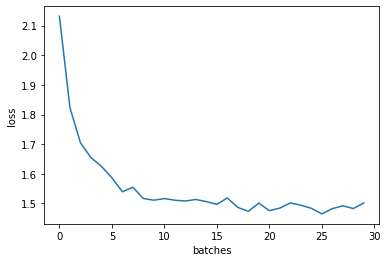

In [ ]:
plt.plot(cross_entropy_losses)
plt.ylabel('loss')
plt.xlabel('batches')
plt.show()

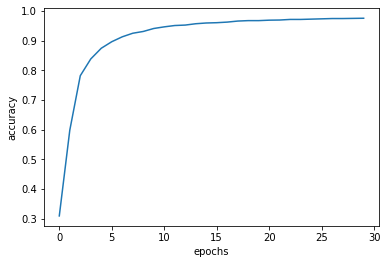

In [ ]:
plt.plot(train_accuracy)
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.show()

In [ ]:
# retrain last layer of fair model to predict the digits and the origin of the data set
model_new = keras.models.clone_model(model)
model_new.set_weights(model.get_weights()) 
model_new._layers.pop()
for layer in model_new.layers: layer.trainable = False  

# recover the output from the last layer in the model and use as input to new Dense layer
last = model_new.layers[-1].output
outputSet = keras.layers.Dense(2, activation="softmax", name="outputSet")(last)
outputNrs = keras.layers.Dense(num_classes, activation="softmax", name="outputNrs")(last)
model_new = keras.models.Model(model_new.input, [outputNrs, outputSet])

for layer in model_new.layers:
    print(layer, layer.trainable)
    
model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics={"outputSet":'accuracy', "outputNrs":'accuracy'})

model_new.summary()

y_train_not_rotated = np.ones(num_train_samples)
y_train_rotated = np.zeros(num_train_samples)

y_test_not_rotated = np.ones(10000)
y_test_rotated = np.zeros(10000)

y_train_set = keras.utils.to_categorical(np.concatenate((y_train_not_rotated,y_train_rotated)), 2)
y_test_set = keras.utils.to_categorical(np.concatenate((y_test_not_rotated,y_test_rotated)), 2)

history = model_new.fit(np.concatenate((x_train, x_train_rot)), [np.concatenate((y_train, y_train)),y_train_set],
                    batch_size=batch_size,
                    epochs=60,
                    verbose=1,
                    validation_data=(np.concatenate((x_test, x_test_rot)), [np.concatenate((y_test, y_test)),y_test_set]))
score = model_new.evaluate(np.concatenate((x_test, x_test_rot)), [np.concatenate((y_test, y_test)),y_test_set], verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fc2727bd668> False
<tensorflow.python.keras.layers.core.Dense object at 0x7fc2727bd5c0> False
<tensorflow.python.keras.layers.core.Dense object at 0x7fc2727bde80> False
<tensorflow.python.keras.layers.core.Dense object at 0x7fc272745048> False
<tensorflow.python.keras.layers.core.Dense object at 0x7fc27275d668> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fc2727bd4a8> True
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          100480      input_1[0][0]                    
____________________________

In [ ]:
# preparation for TSNE plot
layer_of_interest=3
intermediate_layer_model = keras.models.Model(inputs=model_new.input,
                                 outputs=model_new.get_layer("dense_2").output)
intermediates = intermediate_layer_model.predict(np.concatenate((x_test, x_test_rot)))
colors = ["blue", "green", "red", "yellow", "orange", "grey", "black", "pink", "purple", "brown"]
color_intermediates = np.array(colors)[np.argmax(np.concatenate((y_test,y_test)), axis=1)]

tsne = TSNE(n_components=2, random_state=0)
intermediates_tsne = tsne.fit_transform(intermediates)

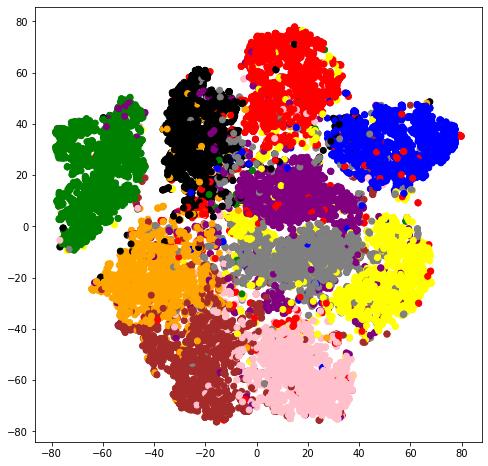

In [ ]:
# TSNE for digits
plt.figure(figsize=(8, 8))
plt.scatter(x = intermediates_tsne[:,0], y=intermediates_tsne[:,1], facecolors='none', edgecolors=color_intermediates)
plt.show()

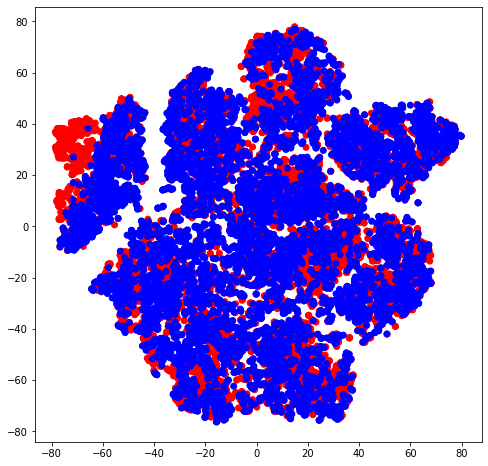

In [ ]:
# TSNE for data set origin (rotated/ not rotated)
colors = ["blue", "red"]
labels = np.concatenate((y_test_not_rotated,y_test_rotated)).astype(int)
color_intermediates = np.array(colors)[labels]
plt.figure(figsize=(8, 8))
plt.scatter(x = intermediates_tsne[:,0], y=intermediates_tsne[:,1], facecolors='none', edgecolors=color_intermediates)
plt.show()

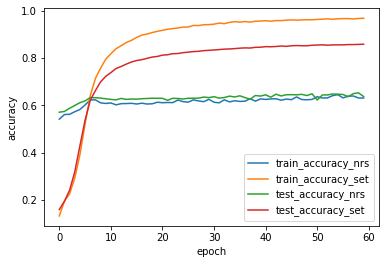

In [ ]:
plt.plot(history.history['outputSet_accuracy'])
plt.plot(history.history['outputNrs_accuracy'])
plt.plot(history.history['val_outputSet_accuracy'])
plt.plot(history.history['val_outputNrs_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy_set', 'train_accuracy_nrs','test_accuracy_set','test_accuracy_nrs'], loc='best')
plt.show()